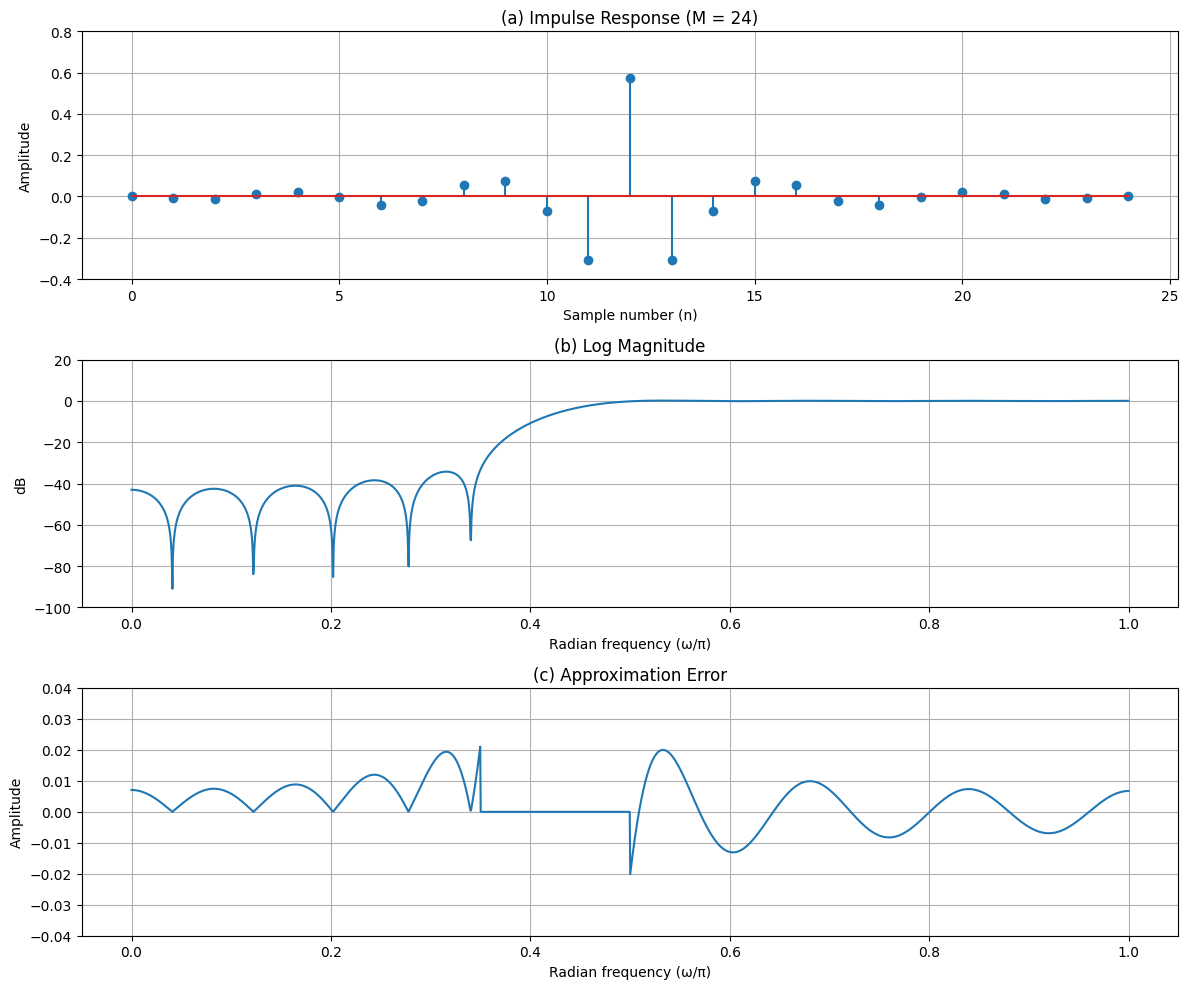

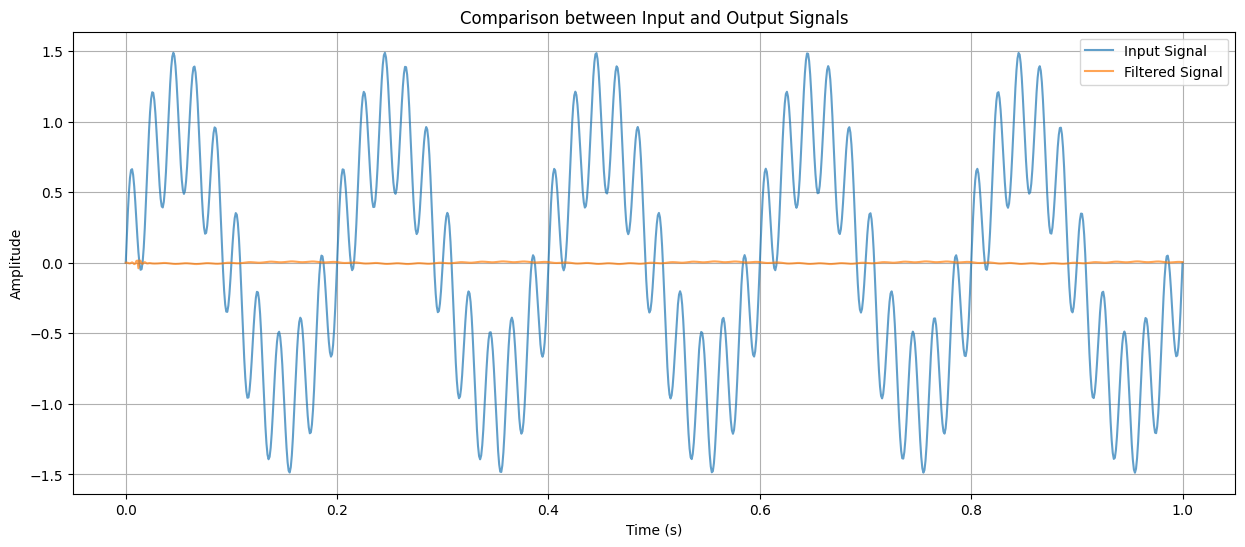

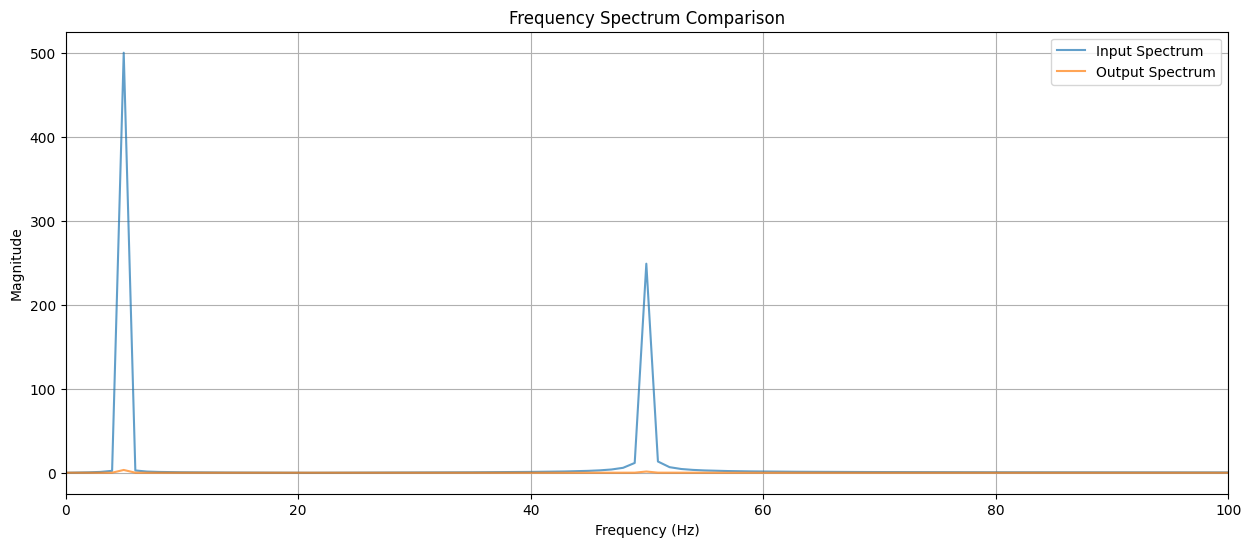

In [2]:
import numpy as np
from scipy import special
from scipy import signal
import matplotlib.pyplot as plt

# Parâmetros do filtro passa-altas
ws = 0.35 * np.pi  # frequência de corte da banda de rejeição
wp = 0.50 * np.pi  # frequência de corte da banda de passagem
delta = 0.02       # erro máximo de aproximação
M = 24            # ordem do filtro (número de coeficientes - 1)

# 1. Cálculo da frequência de corte do filtro ideal
wc = (wp + ws) / 2

# 2. Cálculo dos parâmetros da janela Kaiser
dw = wp - ws
A = -20 * np.log10(delta)  # Atenuação em dB
beta = 2.65

# 3. Geração do filtro
n = np.arange(M + 1)
alpha = M / 2
h = np.zeros(M + 1)

# Cálculo da resposta ao impulso do filtro passa-altas
for i in n:
    if i == alpha:
        h[i] = 1 - (wc / np.pi)
    else:
        h[i] = (np.sin(np.pi * (i - alpha)) - np.sin(wc * (i - alpha))) / (np.pi * (i - alpha))
    
    # Aplicação da janela Kaiser
    if abs(i - alpha) <= alpha:
        beta_term = beta * np.sqrt(1 - ((i - alpha)/alpha)**2)
        window = special.i0(beta_term) / special.i0(beta)
        h[i] *= window

# Cálculo da resposta em frequência
w, H = signal.freqz(h, 1, 2048)
mag_db = 20 * np.log10(np.abs(H))

# Cálculo do erro de aproximação
def calc_error(w, H):
    error = np.zeros_like(w)
    for i, freq in enumerate(w):
        if freq <= ws:
            error[i] = np.abs(H[i])
        elif freq >= wp:
            error[i] = np.abs(H[i]) - 1
    return error

error = calc_error(w, H)

# Plotagem dos resultados
plt.figure(figsize=(12, 10))

# Plot da resposta ao impulso
plt.subplot(3, 1, 1)
plt.stem(n, h)
plt.grid(True)
plt.xlabel('Sample number (n)')
plt.ylabel('Amplitude')
plt.title('(a) Impulse Response (M = 24)')
plt.ylim(-0.4, 0.8)

# Plot da magnitude em dB
plt.subplot(3, 1, 2)
plt.plot(w/np.pi, mag_db)
plt.grid(True)
plt.xlabel('Radian frequency (ω/π)')
plt.ylabel('dB')
plt.ylim(-100, 20)
plt.title('(b) Log Magnitude')

# Plot do erro de aproximação
plt.subplot(3, 1, 3)
plt.plot(w/np.pi, error)
plt.grid(True)
plt.xlabel('Radian frequency (ω/π)')
plt.ylabel('Amplitude')
plt.ylim(-0.04, 0.04)
plt.title('(c) Approximation Error')

plt.tight_layout()
plt.show()

# Demonstração com sinal de teste
t = np.linspace(0, 1, 1000)
# Sinal de baixa frequência (deve ser atenuado)
low_freq = np.sin(2 * np.pi * 5 * t)
# Sinal de alta frequência (deve passar)
high_freq = 0.5 * np.sin(2 * np.pi * 50 * t)
# Sinal de entrada combinado
input_signal = low_freq + high_freq

# Filtrando o sinal
output_signal = signal.lfilter(h, 1, input_signal)

# Plot comparativo dos sinais
plt.figure(figsize=(15, 6))
plt.plot(t, input_signal, label='Input Signal', alpha=0.7)
plt.plot(t, output_signal, label='Filtered Signal', alpha=0.7)
plt.grid(True)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Comparison between Input and Output Signals')
plt.legend()
plt.show()

# Análise espectral
plt.figure(figsize=(15, 6))
input_fft = np.fft.fft(input_signal)
output_fft = np.fft.fft(output_signal)
freq = np.fft.fftfreq(len(t), t[1] - t[0])

positive_freq = freq[:len(freq)//2]
input_spectrum = np.abs(input_fft)[:len(freq)//2]
output_spectrum = np.abs(output_fft)[:len(freq)//2]

plt.plot(positive_freq, input_spectrum, label='Input Spectrum', alpha=0.7)
plt.plot(positive_freq, output_spectrum, label='Output Spectrum', alpha=0.7)
plt.grid(True)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum Comparison')
plt.legend()
plt.xlim(0, 100)
plt.show()